# Image Classification of Dogs vs. Cats With PyTorch

### Imports & Environment

In [ ]:
!pip install ipdb

In [1]:
import os
import random
import collections
import shutil
import time
import glob
import csv
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F


from PIL import Image

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data/data_splitted'

### Config & Hyperparameters

In [2]:
# paths
data_path = DATA_HOME_DIR #+ '/' 
split_train_path = data_path + '/train/'
valid_path = data_path + '/valid/'
test_path = data_path + '/test/'
full_train_path = data_path + '/train_full/'


saved_model_path = ROOT_DIR + '/models/'
submission_path = ROOT_DIR + '/submissions/'

# data
batch_size = 4

# model
nb_runs = 1
nb_aug = 3
epochs = 40
lr = 1e-3
clip = 0.001
archs = [ "resnet101", "resnet50", "resnet18","resnet34"]
archs = ["resnet34"]
best_prec1 = 0

model_names = sorted(name for name in models.__dict__ if name.islower() and not name.startswith("__"))

In [3]:
#model_names

### Helper Functions for Training

In [4]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
    end = time.time()
    
    # switch to train mode
    model.train()
    
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        image_var = torch.autograd.Variable(images)
        label_var = torch.autograd.Variable(target)

        # compute y_pred
        y_pred = model(image_var)
        loss = criterion(y_pred, label_var)

        # measure accuracy and record loss
        prec1, prec1 = accuracy(y_pred.data, target, topk=(1, 1))
        losses.update(loss.data, images.size(0))
        acc.update(prec1, images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

In [5]:
def validate(val_loader, model, criterion, epoch, lr=0.001):
    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):
        labels = labels.cuda()
        image_var = torch.autograd.Variable(images)
        label_var = torch.autograd.Variable(labels)

        # compute y_pred
        y_pred = model(image_var)
        loss = criterion(y_pred, label_var)

        # measure accuracy and record loss
        prec1, temp_var = accuracy(y_pred.data, labels, topk=(1, 1))
        losses.update(loss.data, images.size(0))
        acc.update(prec1, images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print('   * EPOCH {epoch:02d} | Accuracy: {acc.avg:.3f} | Loss: {losses.avg:.3f} | Lr: {lr:.3e}'.format(epoch=epoch,
                                                                                         acc=acc,
                                                                                         losses=losses, lr=lr))

    return acc.avg

In [6]:
def test(test_loader, model):
    csv_map = collections.defaultdict(float)
    
    # switch to evaluate mode
    model.eval()
    
    for aug in range(nb_aug):
        print("   * Predicting on test augmentation {}".format(aug + 1))
        
        for i, (images, filepath) in enumerate(test_loader):
            # pop extension, treat as id to map
            filepath = os.path.splitext(os.path.basename(filepath[0]))[0]
            filepath = int(filepath)

            image_var = torch.autograd.Variable(images)
            y_pred = model(image_var)
            # get the index of the max log-probability
            smax = nn.Softmax()
            smax_out = smax(y_pred)[0]
            cat_prob = smax_out.data[0]
            dog_prob = smax_out.data[1]
            prob = dog_prob
            if cat_prob > dog_prob:
                prob = 1 - cat_prob
            prob = np.around(prob.cpu(), decimals=4)
            prob = np.clip(prob, clip, 1-clip)
            csv_map[filepath] += (prob / nb_aug)

    sub_fn = submission_path + '{0}epoch_{1}clip_{2}runs'.format(epochs, clip, nb_runs)
    
    for arch in archs:
        sub_fn += "_{}".format(arch)
        
    print("Writing Predictions to CSV...")
    with open(sub_fn + '.csv', 'w') as csvfile:
        fieldnames = ['id', 'label']
        csv_w = csv.writer(csvfile)
        csv_w.writerow(('id', 'label'))
        for row in sorted(csv_map.items()):
            csv_w.writerow(row)
    print("Done.")

In [7]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')      

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    global lr
    lr = lr * (0.1**(epoch // 30))
    for param_group in optimizer.state_dict()['param_groups']:
        param_group['lr'] = lr


def accuracy(y_pred, y_actual, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = y_actual.size(0)

    _, pred = y_pred.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y_actual.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res

In [10]:
class TestImageFolder(data.Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in sorted(glob.glob(test_path + "*.jpg")):
            images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [11]:
def shear(img):
    width, height = img.size
    m = random.uniform(-0.05, 0.05)
    xshift = abs(m) * width
    new_width = width + int(round(xshift))
    img = img.transform((new_width, height), Image.AFFINE,
                        (1, m, -xshift if m > 0 else 0, 0, 1, 0),
                        Image.BICUBIC)
    return img

class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

### Main Training Loop

#### dataset loading

In [71]:
# Data loading code
traindir = split_train_path
valdir = valid_path
testdir = test_path

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#transforms.RandomApply
#transforms.RandomAffine, RandomPerspective
train_loader = data.DataLoader(
    datasets.ImageFolder(traindir,
                         transforms.Compose([
                             # transforms.Lambda(shear),
                             SquarePad(),
                             transforms.Resize(224),
                             transforms.ColorJitter(
                                brightness=0.1,
                                contrast=0.1,
                                saturation=0.1,
                                hue=0.1,
                             ),
                             transforms.RandomApply(transforms=
                                             [transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 1.5))],
                                         p=.3),                                         
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             normalize,
                         ])),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True)

val_loader = data.DataLoader(
    datasets.ImageFolder(valdir,
                         transforms.Compose([
                             SquarePad(),
                             transforms.Resize(224),
                             transforms.ColorJitter(
                                brightness=0.1,
                                contrast=0.1,
                                saturation=0.1,
                                hue=0.1
                             ),
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             normalize,
                         ])),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True)

test_loader = data.DataLoader(
    datasets.ImageFolder(testdir,
                    transforms.Compose([
                        # transforms.Lambda(shear),
                        # transforms.Resize(256),
                        # transforms.CenterCrop(224),
                        SquarePad(),
                        transforms.Resize(224),                                
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize,
                    ])),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=False)


dataa ={'train':train_loader, 'valid':val_loader, 'test':test_loader}

In [13]:
train_loader.dataset.class_to_idx

{'cemento': 0,
 'no_truck': 1,
 'otro': 2,
 'plataforma': 3,
 'volteo': 4,
 'volteo_corto': 5}

In [14]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
find_classes(traindir)

(['cemento', 'no_truck', 'otro', 'plataforma', 'volteo', 'volteo_corto'],
 {'cemento': 0,
  'no_truck': 1,
  'otro': 2,
  'plataforma': 3,
  'volteo': 4,
  'volteo_corto': 5})

In [15]:
from collections import Counter
dd = dict(Counter(train_loader.dataset.targets))
summ = sum([k for k in dd.values()])/len(dd.values())
summ
dd2 = {k[0]:round(summ/k[1],0) for k in dd.items()}
dd2,dd

({0: 1.0, 1: 1.0, 2: 2.0, 3: 9.0, 4: 0.0, 5: 2.0},
 {0: 400, 1: 240, 2: 141, 3: 33, 4: 749, 5: 141})

In [16]:
weights = list(dd.values())
class_weights = torch.FloatTensor(weights).cuda()

In [17]:
def main(data,mode="train", resume=False, num_clases=6, lr = 0.001, weights=None):
    
    global best_prec1
    
    for arch in archs:

        # create model
        print("=> Starting {0} on '{1}' model".format(mode, arch))
        model = models.__dict__[arch](pretrained=True)
        # Don't update non-classifier learned features in the pretrained networks
        for param in model.parameters():
            param.requires_grad = False
        # Replace the last fully-connected layer
        # Parameters of newly constructed modules have requires_grad=True by default
        # Final dense layer needs to replaced with the previous out chans, and number of classes
        # in this case -- resnet 101 - it's 2048 with two classes (cats and dogs)
        #print(model)
        #import ipdb; ipdb.set_trace()
        
        model.fc = nn.Linear(model.fc.in_features, num_clases)

        if arch.startswith('alexnet') or arch.startswith('vgg'):
            model.features = torch.nn.DataParallel(model.features)
            model.cuda()
        else:
            model = torch.nn.DataParallel(model).cuda()
            
        # optionally resume from a checkpoint
        if resume:
            if os.path.isfile(resume):
                print("=> Loading checkpoint '{}'".format(resume))
                checkpoint = torch.load(resume)
                start_epoch = checkpoint['epoch']
                best_prec1 = checkpoint['best_prec1']
                model.load_state_dict(checkpoint['state_dict'])
                print("=> Loaded checkpoint (epoch {})".format(checkpoint['epoch']))
            else:
                print("=> No checkpoint found at '{}'".format(args.resume))

        cudnn.benchmark = True

        
        
        
        if mode == "test":
            test(data['test'], model)
            return
        
        # define loss function (criterion) and pptimizer
        criterion = nn.CrossEntropyLoss(weight=weights).cuda()
        
        if mode == "validate":
            validate(data['valid'], model, criterion, 0)
            return

        optimizer = optim.SGD(model.module.fc.parameters(), lr=lr,weight_decay=1e-4, momentum=0.9)
        #optimizer = optim.Adam(model.module.fc.parameters(), lr, weight_decay=1e-4)
        scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        
        for epoch in range(epochs):
            #adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            train(data['train'], model, criterion, optimizer, epoch)
            scheduler1.step()
            #import ipdb; ipdb.set_trace()
                        
            # evaluate on validation set
            cur_lr = optimizer.param_groups[-1]['lr']
            prec1 = validate(data['valid'], model, criterion, epoch,cur_lr)

            # remember best Accuracy and save checkpoint
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': arch,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)

### Run Train

In [ ]:
import ipdb

In [28]:
main(dataa, mode="train", weights=class_weights, lr=5e-4)

=> Starting train on 'resnet34' model
   * EPOCH 00 | Accuracy: 54.815 | Loss: 0.790 | Lr: 4.500e-04
   * EPOCH 01 | Accuracy: 51.111 | Loss: 1.006 | Lr: 4.050e-04
   * EPOCH 02 | Accuracy: 61.728 | Loss: 0.701 | Lr: 3.645e-04
   * EPOCH 03 | Accuracy: 68.395 | Loss: 0.643 | Lr: 3.281e-04
   * EPOCH 04 | Accuracy: 69.136 | Loss: 0.582 | Lr: 2.952e-04
   * EPOCH 05 | Accuracy: 68.148 | Loss: 0.625 | Lr: 2.657e-04
   * EPOCH 06 | Accuracy: 70.123 | Loss: 0.606 | Lr: 2.391e-04
   * EPOCH 07 | Accuracy: 61.975 | Loss: 0.634 | Lr: 2.152e-04
   * EPOCH 08 | Accuracy: 68.148 | Loss: 0.536 | Lr: 1.937e-04
   * EPOCH 09 | Accuracy: 63.457 | Loss: 0.605 | Lr: 1.743e-04
   * EPOCH 10 | Accuracy: 69.877 | Loss: 0.556 | Lr: 1.569e-04
   * EPOCH 11 | Accuracy: 69.877 | Loss: 0.572 | Lr: 1.412e-04
   * EPOCH 12 | Accuracy: 67.654 | Loss: 0.607 | Lr: 1.271e-04
   * EPOCH 13 | Accuracy: 64.444 | Loss: 0.535 | Lr: 1.144e-04
   * EPOCH 14 | Accuracy: 69.383 | Loss: 0.570 | Lr: 1.029e-04
   * EPOCH 15 | A

In [18]:
main(dataa, mode="validate", resume='model_best.pth.tar')

=> Starting validate on 'resnet34' model
=> Loading checkpoint 'model_best.pth.tar'
=> Loaded checkpoint (epoch 25)
   * EPOCH 00 | Accuracy: 71.358 | Loss: 0.917 | Lr: 1.000e-03


### Run Test

In [ ]:
main(mode="test", resume='model_best.pth.tar')

In [48]:
model = models.__dict__[archs[0]](pretrained=True)
# Don't update non-classifier learned features in the pretrained networks
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 6)
model = torch.nn.DataParallel(model).cuda()

resume='model_best.pth.tar'
checkpoint = torch.load(resume)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
model.load_state_dict(checkpoint['state_dict'])

model.eval()


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [79]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [68]:
from PIL import Image
import cv2
import torch.nn.functional as FF
from tqdm.auto import tqdm
def process_file(filepath,model, categories):
    img_cv2 = cv2.imread(filepath)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
    TRANSFORMS = transforms.Compose([
            SquarePad(),
            transforms.Resize(224),
            transforms.ToTensor(),
            normalize]
            )
    img = Image.fromarray(img_cv2)
    image = TRANSFORMS(img).unsqueeze(0).cuda()
    y = model(image)
    #print(f"---{filepath}---")
    #print('Result:',y)
    output = FF.softmax(y, dim=1).detach().cpu().numpy().flatten()
    #print('Output:',output)
    #print('Result max:',categories[np.argmax(output)])
    return categories[np.argmax(output)]

def process_folder(folder,model, categories):
    values=[]
    for file in tqdm(os.listdir(folder)):
        filepath = os.path.join(folder, file)
        output = process_file(filepath, model, categories)
        values.append(output)
    return values
categories,_ = find_classes(traindir)
print(categories)

values = process_folder(test_path+'cemento/test/', model, categories)
Counter(values)

['cemento', 'no_truck', 'otro', 'plataforma', 'volteo', 'volteo_corto']


  0%|          | 0/32 [00:00<?, ?it/s]

Counter({'cemento': 28, 'volteo': 4})

In [67]:
Counter(values)

Counter({'cemento': 28, 'volteo': 4})

In [69]:
torch.save(model, 'trucks_resnet_34_prod.pt')

In [70]:
# Model class must be defined somewhere
model2 = torch.load('trucks_resnet_34_prod.pt')
model2.eval()

values = process_folder(test_path+'cemento/test/', model, categories)
Counter(values)

  0%|          | 0/32 [00:00<?, ?it/s]

Counter({'cemento': 28, 'volteo': 4})

## Matriz de confusion

In [76]:
train_preds = get_all_preds(model, test_loader)

In [97]:
N = len(test_loader.dataset.targets)
targets = torch.tensor(test_loader.dataset.targets).cuda()
preds_correct = get_num_correct(train_preds, targets)
preds = train_preds.argmax(dim=1)
print('total correct:', preds_correct)
print('accuracy:', preds_correct / N)

total correct: 145
accuracy: 0.7323232323232324


<AxesSubplot:>

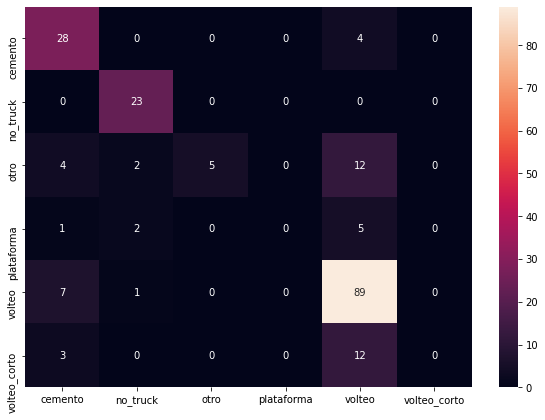

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_true = test_loader.dataset.targets
y_pred = train_preds.argmax(dim=1).cpu().tolist()

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = categories,
                  columns = categories)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
!pip install seaborn

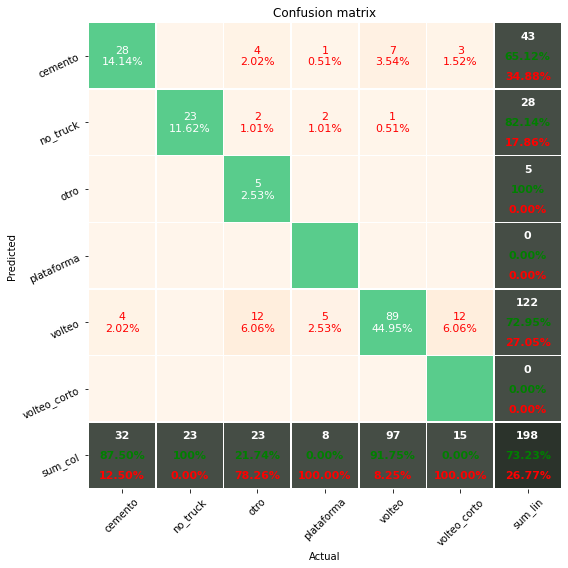

In [109]:
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data, pretty_plot_confusion_matrix
pretty_plot_confusion_matrix(df_cm)


In [140]:
#aca qe tire error y no se ejecte nada
kakak
dirs = [dirr for dirr in os.listdir(data_dir) if dirr!='content']
dirs

for dd in dirs:
    fold = os.path.join(data_dir,dd)
    subs = os.listdir(fold)
    for sub in subs:
        sss = os.path.join(data_dir, dd, sub, dd)
        ss = os.path.join(data_dir, dd, sub)
        if os.path.exists(sss):
            %mv {sss}/*.* {ss}
            %rm -r {sss}
            
    


mv: cannot stat '/home/user/pmptests/train_truck_classifier/data/data_splitted/train/cemento/train/*.*': No such file or directory
mv: cannot stat '/home/user/pmptests/train_truck_classifier/data/data_splitted/test/cemento/test/*.*': No such file or directory
